In [ ]:
from generate_data import *
from utils import *
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")

global k, vk

In [9]:
Ts = 0.1

N = 10
Nu = 8
Lambda = 5e-6

# 1 - population, 2 - tracking, 3 - hiv
process = 2

In [ ]:
y_zad, fun, x, u, bds, model = initialize(process, N, Nu, Ts)
model.print(precision=int(3 - np.log10(Ts)))

y_zad_N = np.vstack([y_zad, np.tile(y_zad[-1], (N, 1))])
kmax, vk = len(y_zad), 0

(x1)[k+1] = 0.9121 x1[k] + 0.0999 x3[k] + -0.0228 u[k] + 0.0443 x1[k]^2 + 0.0016 x1[k] x2[k] + -0.0088 x1[k] x3[k] + -0.0125 x1[k] u[k] + -0.0018 x2[k]^2 + 0.0005 x2[k] x3[k] + 0.0096 x2[k] u[k] + -0.0001 x3[k]^2 + 0.3783 x1[k]^3 + 0.0097 x1[k]^2 x2[k] + -0.0984 x1[k]^2 x3[k] + -0.0028 x1[k] x2[k]^2 + -0.0001 x1[k] x2[k] x3[k] + 0.0457 x1[k] x2[k] u[k] + -0.0004 x1[k] x3[k]^2 + -0.0002 x2[k]^3 + -0.0008 x2[k]^2 x3[k] + -0.0172 x2[k]^2 u[k] + 0.0003 x2[k] x3[k]^2 + 0.0001 x3[k]^3
(x2)[k+1] = 1.0000 x2[k] + 0.1000 x3[k]
(x3)[k+1] = -0.4246 x1[k] + 0.9579 x3[k] + -2.1160 u[k] + -0.0997 x1[k]^2 + 0.0265 x1[k] x2[k] + -0.0091 x1[k] x3[k] + -0.1902 x1[k] u[k] + 0.0003 x2[k]^2 + 0.0177 x2[k] x3[k] + 0.1375 x2[k] u[k] + -0.0008 x3[k]^2 + -0.0099 x3[k] u[k] + -0.4881 x1[k]^3 + 0.1907 x1[k]^2 x2[k] + 0.0166 x1[k]^2 x3[k] + -0.0462 x1[k] x2[k]^2 + 0.0326 x1[k] x2[k] x3[k] + 0.7027 x1[k] x2[k] u[k] + -0.0052 x1[k] x3[k]^2 + -0.0005 x2[k]^3 + -0.0317 x2[k]^2 x3[k] + -0.2447 x2[k]^2 u[k] + 0.0033 x2

In [11]:
def mpc_no(deltau, model=None, w=1):
    u[k:k+Nu] = (np.tril(np.ones((Nu, Nu)), 0) @ deltau.reshape(-1, 1) + u[k-1] * np.ones((Nu,1))).reshape(-1)
    u[k+Nu:k+N+1] = u[k+Nu-1]

    if model is not None:
        for p in range(N+1):
            x[k+p] = model.simulate(x[k+p-1], t=2, u=np.array([u[k+p-1]]))[-1] + vk
    else:
        for p in range(N+1):
            x[k+p] = fun(t=0, state=x[k+p-1], T=Ts, u=u[k+p-1])

    return norm((y_zad_N[k]*w).reshape(-1, 1)*np.ones((1, N)) - (x[k+1:k+N+1]*w).T, 2) + Lambda * norm(deltau, 2)

In [18]:
state = x[0]
w = [1, 0, 0]

for k in range(5, kmax):
    xmod =  model.simulate(state, t=2, u=np.array([u[k-1]]))[-1]
    state = fun(t=0, state=state, T=Ts, u=u[k-1])

    x[k, :] = state

    try:
        opt = minimize(
            mpc_no,
            args=(None, w),
            x0=np.zeros(Nu),
            method='SLSQP',
            bounds=[(-bds, bds)]*Nu,
            options={'maxiter': 100, 'ftol': 1e-6}
        )
        du = opt.x[0]
    except np.linalg.LinAlgError as e:
        print(f"Optimization failed due to: {e}")
        du = 0
    
    u[k] = u[k-1] + du
    # u[k] = np.clip(u[k], -1, 1)
    vk = state - xmod

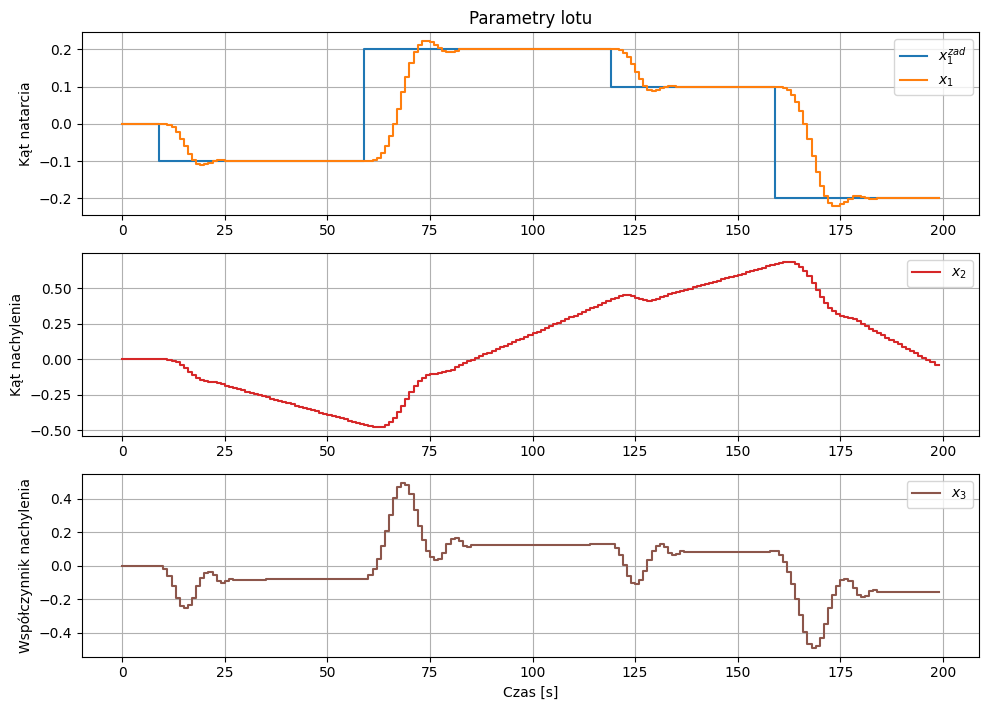

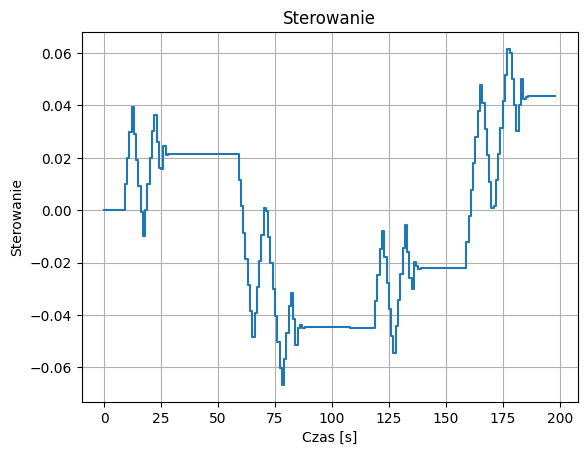

In [19]:
plot(y_zad, x, u, w, save=False)